# AAPL time series modeling:
### Feature engineering for regression models 

In the previous AAPL time series modeling notebook we compare the results of optimized classical time series models and various deep learning neural networks. In this notebook, we will make use of feature engineering and traditional ML models to try to increase the predictive power of our time series model. Hopefully we will also produce a more interpretable model.

#### The general outline of our notebook is a follows:

1. Pull Apple stock price data using API
2. Feature engineering:<br>
a. Create lags.<br>
b. Create rolling means, mins, and maxs.<br>
3. Feature selection/dimension reduction:<br>
a. Drop all features not strongly correlated with target variable.<br>
4. Data prep
5. Compare models :<br>
    a. Linear regression <br>
    b. Linear regression with scaled input <br>
    c. Ridge regression <br>
    d. Lasso regression <br>

In [1]:
# general packages
import seaborn as sns
import pandas as pd
import numpy as np
from warnings import filterwarnings
import matplotlib.pyplot as plt
import ast
import timeit

# math and stats packages
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
from numpy import array, mean, median, std
import warnings
from scipy import stats
from scipy.stats import norm, skew

# api related packages
import requests
import datetime
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader as pdr
import quandl

# settings
warnings.filterwarnings('ignore') #ignore annoying warning (from sklearn and seaborn)
%matplotlib inline
plt.style.use('seaborn')
color = sns.color_palette()
sns.set_style('darkgrid')

### Scrape AAPL (apple) stock price and volume data

In [2]:
quandl.ApiConfig.api_key = "bhnUp4wu_kkHmzfasJWH"

In [3]:
def daily_price_historical(symbol, start_tup, end_tup = datetime.date.today()):
    year_s, month_s, day_s  = start_tup
    start = datetime.datetime(year_s, month_s, day_s)
    end = datetime.date.today()
    if end_tup != datetime.date.today():
        year_e, month_e, day_e = end_tup
        end = datetime.datetime(year_e, month_e, day_e)
    s = symbol
    stock = quandl.get("WIKI/" + s, start_date=start, end_date=end)
    return stock

In [4]:
# consider 'AAL' for non-differenced model
df = daily_price_historical('AAPL', (2016, 9, 21))[['Close', 'Volume']]

In [5]:
#look at data
print('Max length = %s' % len(df))

# check head
df.head()

Max length = 379


,Close,Volume
Date,,
2016-09-21,113.55,36003185.0
2016-09-22,114.62,31073984.0
2016-09-23,112.71,52481151.0
2016-09-26,112.88,29869442.0
2016-09-27,113.09,24607412.0


Since we already performed EDA in our last notebook, we will skip this for now. Also, here we will not be using any classical time series models, so we won't be interested in guessing the parameters for these models like last time.

### Feature engineering

Below we'll create many lag, rolling min, mean, and max features for both close price and volume. 

In [6]:
# create list of orig features
features = df.columns

# iterate over list to create new features
for feat in features:
    for i in range(1,50):
        if i <= 25:
            # create lags for close and volume
            df['{}_lag_{}'.format(feat,i)] = df['{}'.format(feat)].shift(i)
        if  i % 10 == 0:
            # create rolling mean, min, and max features for close and volume
            df['{}_mean_{}'.format(feat,i)] = df['{}'.format(feat)].shift().rolling(i).mean()
            df['{}_min_{}'.format(feat,i)] = df['{}'.format(feat)].shift().rolling(i).min()
            df['{}_max_{}'.format(feat,i)] = df['{}'.format(feat)].shift().rolling(i).max()

Let's use the correlation heat map below to take a set of some of the most highly correlated features with our target.

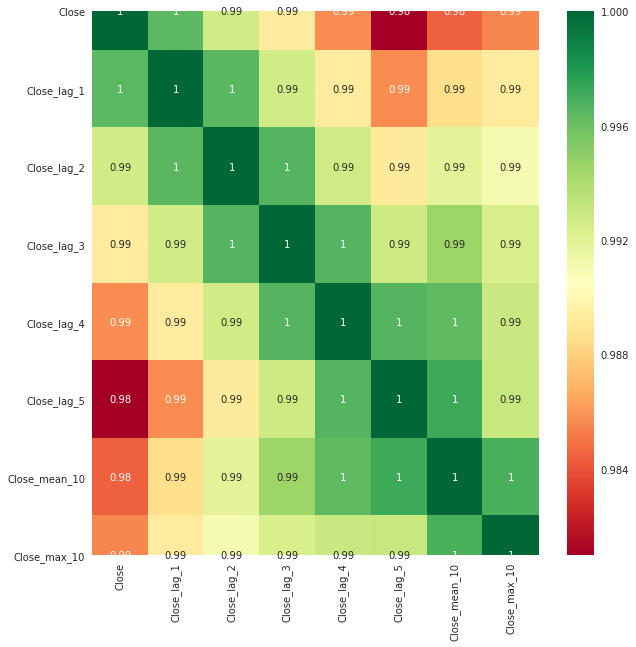

In [7]:
# create correlation map of features most strongly correlated with target
corrmat = df.corr()
top_corr_features = corrmat.index[abs(corrmat["Close"])>0.98]
plt.figure(figsize=(10,10))
g = sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [8]:
# Creating a copy of the initial dataframe to make various transformations 
data = df.copy()
# Dropping weakly correlated features
data = data[top_corr_features].dropna()

### Data prep

Below we import models, loss functions, and work on splitting our data

In [9]:
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.metrics import mean_squared_error

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=10)

In [10]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [11]:
data.rename(columns = {'Close':'y'}, inplace = True)
y = data['y']
X = data.drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.2)

In [12]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# root mean squared error or rmse
def measure_rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

Let's also define a couple functions to model our results

In [13]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = np.sqrt(-cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_squared_error"))
        mse = cv.mean() 
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mse + scale * deviation)
        upper = prediction + (mse + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = measure_rmse(prediction, y_test)
    plt.title("Root mean squared error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

### Modeling

#### Linear regression model 

In [14]:
# vanilla linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

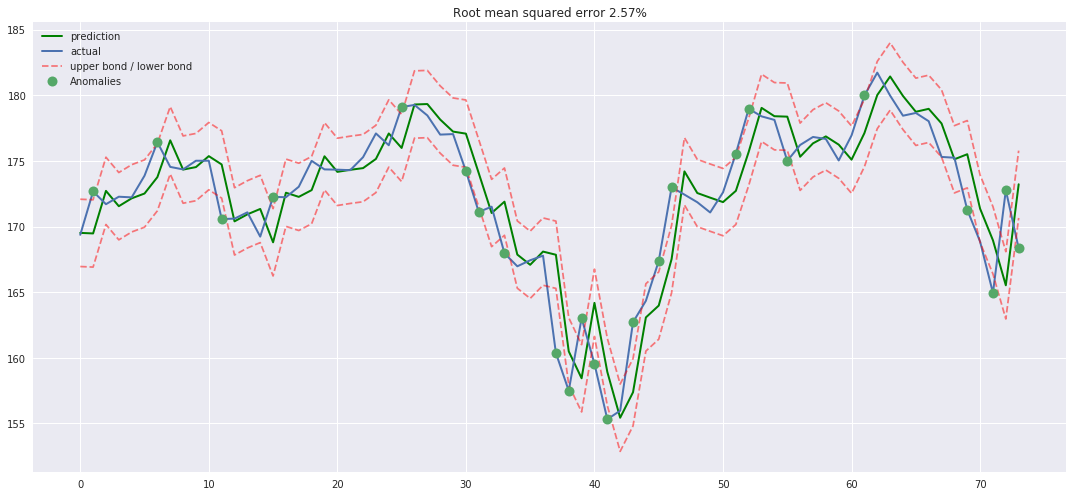

In [15]:
plotModelResults(lr, plot_intervals=True, plot_anomalies = True)

In general, our forcast looks pretty good considering all the anomalies the real time series had. 

RMSE of 2.57 also outperforms the optimized persistence, exponential smoothing, and deep learning models from our previous notebook. So we're off to a pretty good start.

#### Plot model coefficients for linear regression

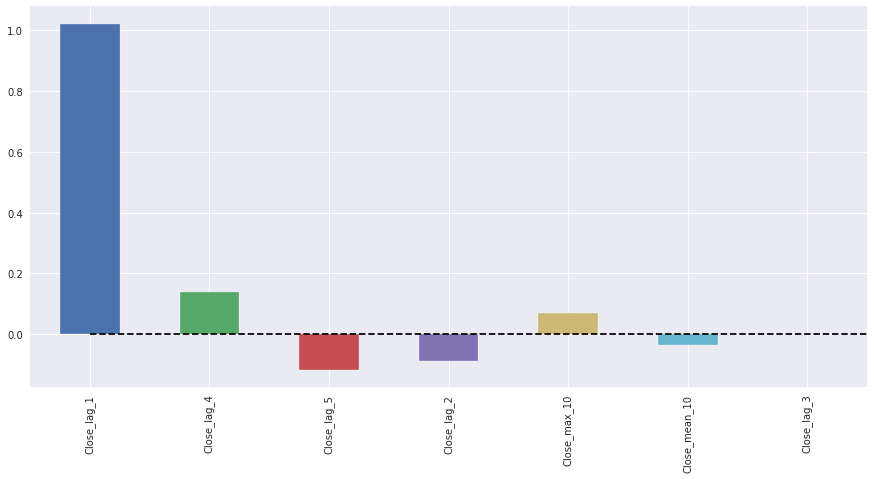

In [16]:
plotCoefficients(lr)

We can see that the most predictive power for our linear regression model came from Close_lag_1. Said another way, the most important feature for predicting tomorrow's closing price is today's closing price.

Also interesting to see the other features with important coefficients in our model 

#### Linear regression with standard scalar

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

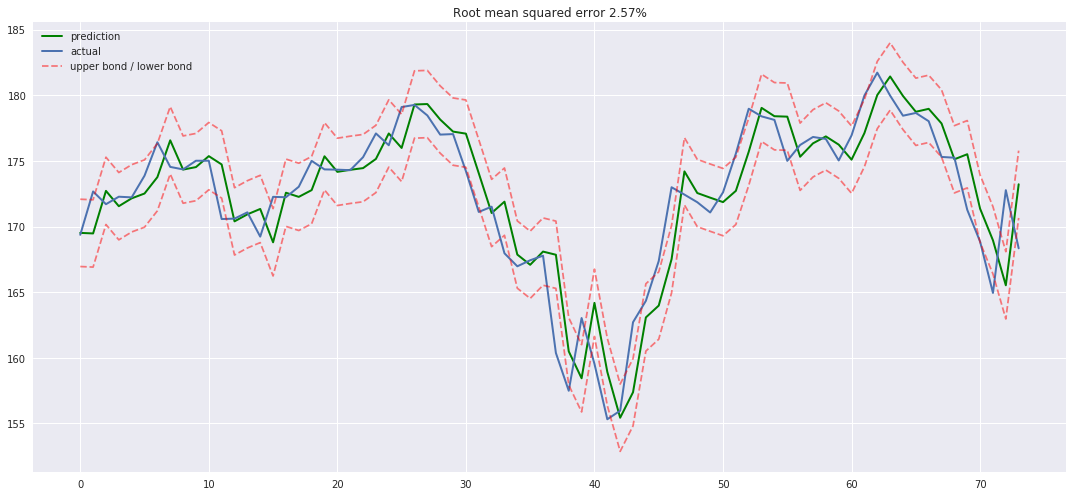

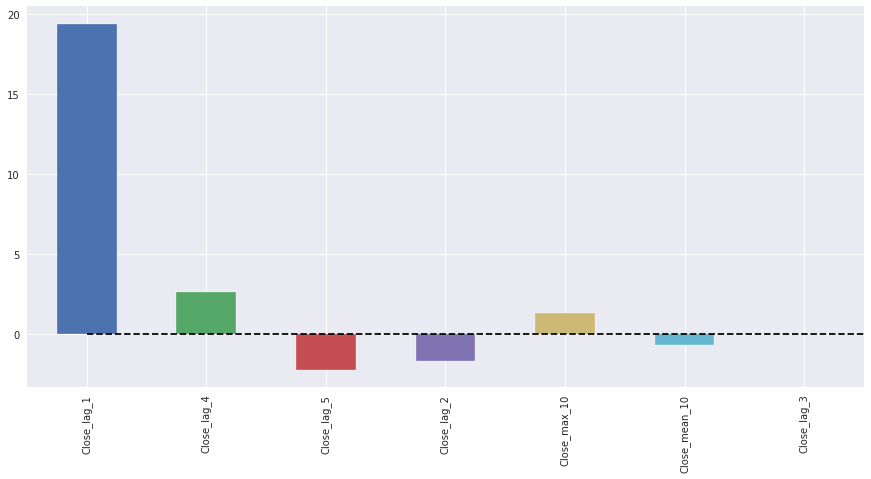

In [18]:
# X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

Scaling the input data didn't improve our model's performance in this case or any of the following regression models, so we will not scale again in this notebook

### Regularized linear regression models

#### Ridge regression

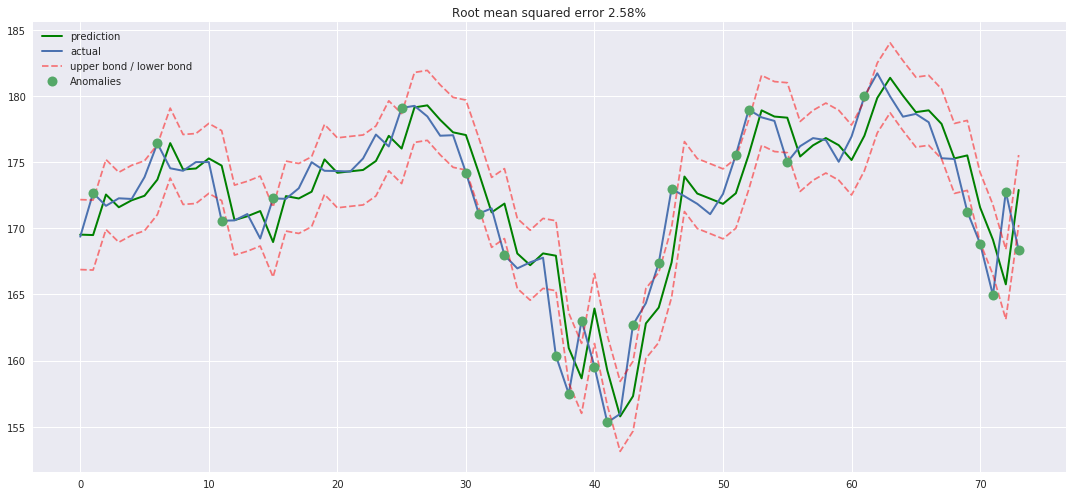

In [19]:
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

The RMSE of 2.58 acheived here by the ridge regression is worse than the RMSE of 2.57 for the regular linear regression model. But both outperform the optimized persistence, exponential smoothing, and deep learning models from our previous notebook. 

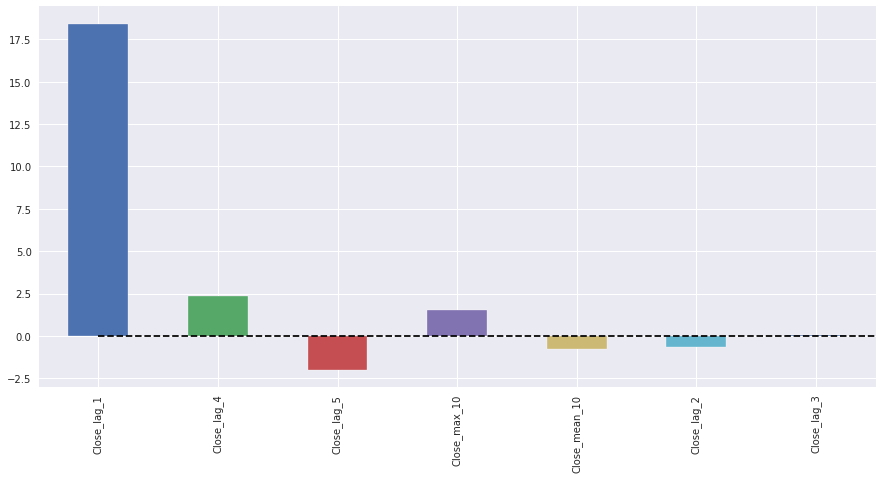

In [20]:
plotCoefficients(ridge)

The features with the largest coefficients in our ridge regression model are very similar to those in the vanilla regression model. Close_lag_1 still leading the pack by a country mile...

#### Lasso regression

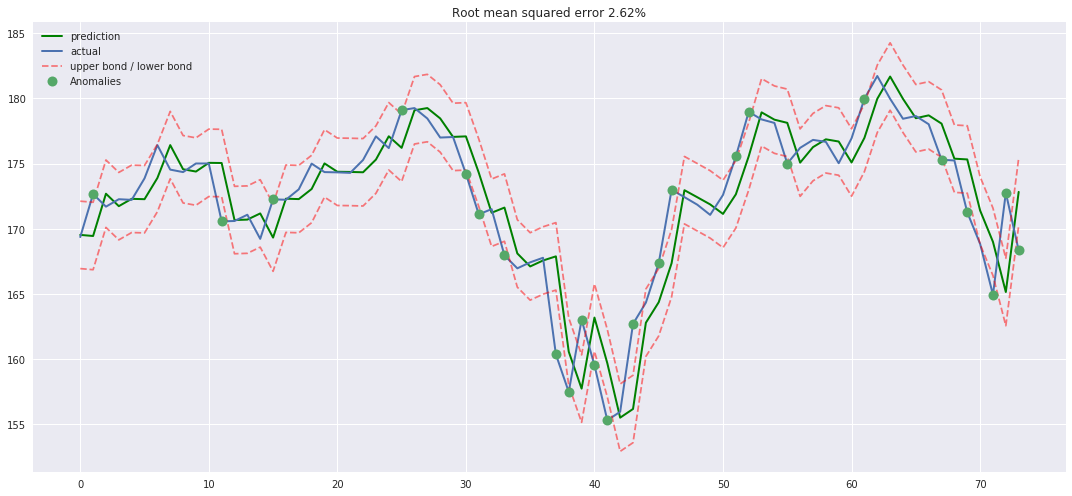

In [21]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train, y_train)

plotModelResults(lasso, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)

The RMSE of 2.62 acheived here by the lasso regression is worse than our other regression models but outperform some of the optimized persistence, exponential smoothing, and deep learning models from our previous notebook. 

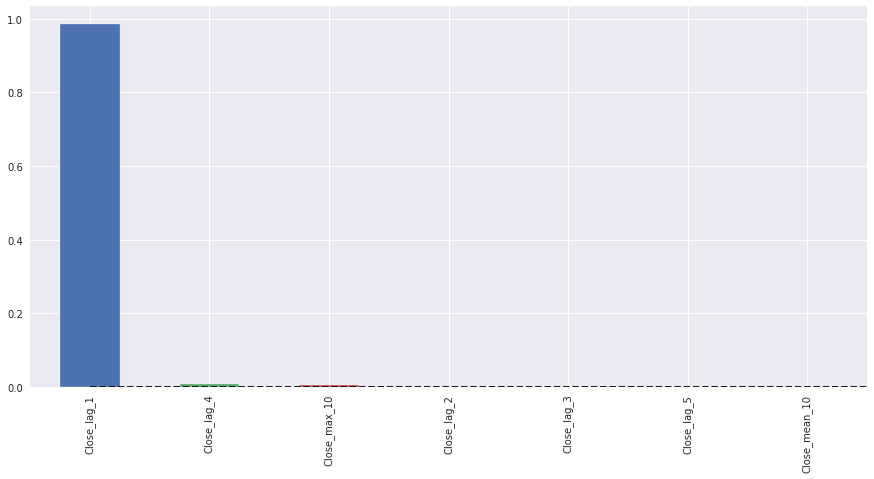

In [22]:
plotCoefficients(lasso)

Lasso regression functions as a feature selector by shrinking all of the less predictive coefficients in our model towards 0. That clearly happened here. This helps to address multicollinearity and overfitting problems that might be occuring in our other models but also gives us a very basic model that is essentially a 1 day persitence model (e.g. tomorrow's close is equal to today); some middle ground would be nice.

### Results

RMSE for our four models:<br>
>Linear regression--2.57<br>
Linear regression with scaled input--2.57<br>
Ridge regression--2.58<br>
Lasso regression--2.62<br>

### Conclusion:

Somewhat surprised to find out how accurate and interpretbale basic feature engineering and linear regression models are compared to some of the sophisticated models optimized in my other notebook. Would gladly use these models in a quick and dirty scenario.

Not surprised to see that the regularized regression models, which are often used to prevent overfitting, seemed to give simpler and less accurate models.

#### Next steps:

1. Engineering more helpful features
2. Use engineer features in neural networks (CNN, LSTM, etc.)
3. Gradient boosting
4. Experiment with regularized regression models more in general